### Chapter 7. Extending the OLG model
Reference: Fehr, H. and Kindermann, F. 2018. The overlapping generations model. Introduction to Computational Economics Using Fortran. Oxford University Press. pp253-286.

In [1]:
##### Program 7.1 The global variables for variable labour supply

import numpy as np

# Parameters
"""
    T: transition path periods
    J: age
    JR: the year household retires
    γ: risk aversion
    egam: denominator of utility function
    β: discount factor
    ν: leisure preference parameter
    ρ: intratemporal elasticity of substitution between consumption and leisure
    eρ: denominator of leisure preference
    α: capital share
    δ: depreciation
    tol: tolerance
    damp: speed of convergence
    itermax: maximum iteration number
    ----------------------------------------------------------------------------
    w: wage rate
    r: rate of capital return
    wn: after tax wage (net wage)
    Rn: after tax capital return
    p: consumption price
    K: aggregate capital
    L: aggregate labour
    A: aggregate assets
    C: aggregate consumption
    I: aggregate investment
    B: aggregate debt
    G: government spending
    k: capital per capita
    μ: shadow price 
    a: savings
    c: consumption
    U: utility
    l: leisure
    Y: aggregate output
    Ba: debt or assets of the agency per capita of workers
    Bf: future period debt B_{t+1}
    Tb: total debt (1+np)B_{t+1}+(1+r)B_t
    TXr: total tax revenue
    Tpen: total pension
"""

def initialize():
    global T, J, JR, γ, egam, β, ν, ρ, eρ, α, δ, tol, damp, itermax, w, r, wn, Rn, p, K, \
    L, A, C, I, B, G, μ, a, c, U, l, Y, Ba, Bf, Tb, TXr, Tpen, k, n_p, gy, by, κ, τk, \
    tax, lsra_on, smopec, τc, τw, τr, τp, pen, v, m

    # Parameters
    T = 24; J = 3; JR = 3; γ = .5; egam = 1.0 - 1.0/γ; β = .9; ν = 1.5
    ρ = .6; eρ = 1.0 - 1.0/ρ; α = .3; δ = .0; tol = 1e-6; damp = 0.3
    itermax = 200

    # Variables
    w  = np.zeros(T+1); r = np.zeros(T+1); wn = np.zeros((J,T+1))
    Rn = np.zeros(T+1); p = np.zeros(T+1); K  = np.zeros(T+1)
    L  = np.zeros(T+1); A = np.zeros(T+1); C  = np.zeros(T+1)
    I  = np.zeros(T+1); B = np.zeros(T+1); G  = np.zeros(T+1)
    k  = np.zeros(T+1); U = np.zeros((J,T+1)); Y = np.zeros(T+1)
    Ba = np.zeros(T+1); Bf = np.zeros(T+1);
    Tb = np.zeros(T+1); TXr = np.zeros(T+1); Tpen = np.zeros(T+1)

    # Set model parameters
    n_p = np.zeros(T+1) + .2    #population growth rate
    gy  = 0.0                   #government spending proportion
    by  = np.zeros(T+1)         #debt proportion
    κ   = np.zeros(T+1)         #pension proportion
    lsra_on = False             #include welfare analysis or not
    smopec = False              #include small open economy or not

    # Initialize tax rates shadow wages and pensions
    τk  = np.zeros(T+1)         #investment tax rate
    τc = np.zeros(T+1)          #consumption tax rate
    τw = np.zeros(T+1)          #labour income tax rate
    τr = np.zeros(T+1)          #capital income tax rate
    τp = np.zeros(T+1)          #payroll tax rate
    tax = np.ones(T+1)          #tax balancing index
    pen = np.zeros((J,T+1))     #pension
    μ = np.zeros((J,T+1))       #shadow price
    if ν > .0:
        μ[JR-1:J,:] = .5        #shadow price >0 for l=1 as retired

    # Initialize assets, LSRA payments and debt holdings
    a = np.zeros((J,T+1))       #assets
    c = np.zeros((J,T+1))       #consumption
    l = np.zeros((J,T+1))       #leisure
    v = np.zeros(T+J-1)         #reqiured transfer


    # Size of cohorts in specific year
    m = np.zeros((J,T+1))       #population parameter
    for t in range(T+1):
        m[0,t] = 1.0            #in period 0, m=1
        itm = year(t, 1, 0)     #time index t-1
        for age in range(1,J):
            m[age,t] = m[age-1,itm]/(1.0 + n_p[t]) #m_{j,t}=m_{j-1,t-1}/(1+np)
    return None

In [2]:
## calculates year at which age j agent is jp
def year(t, j, jp):
    """This function defines the year index"""
    year = t + jp - j  #year i age j period ij (j-1, j+1, j+2)
    if t == 0 or year<=0:
        year = 0       #initial period
    if t == T or year>=T:
        year = T       #last period
    return year

In [3]:
## Function: factor price:
def factor_prices(t):
    """This function defines multidimensional factor price calculation for period i."""
    global k, K, r, w, wn, Rn, p
    k[t]   = K[t]/L[t]                 #per capita capital stock
    if smopec and t > 0:
        r[t] = r[0]
    else:
        r[t] = (1.0 - τk[t])*(α*k[t]**(α-1.0)-δ)  #(1-τk)*r
  
    w[t]   = (1.0 - α)*k[t]**α         #wage rate

    for j in range(J):
        wn[j,t]  = (h[j]*w[t] + μ[j,t])*(1.0 - τw[t] - τp[t])  #the net wage of a j-year-old worker in period t
        
    Rn[t]  = 1.0 + r[t]*(1.0 - τr[t])  #net interest
    p[t]   = 1.0 + τc[t]               #consumer price
    return None

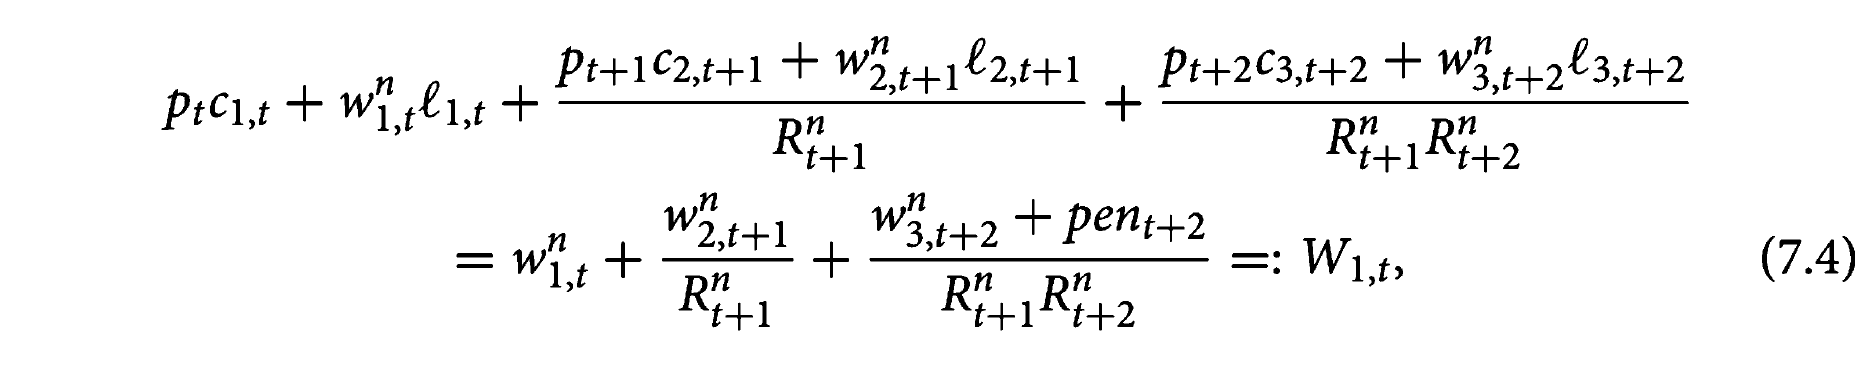

In [4]:
## present value of resources for household aged j in year t
## note: because our index is from 0 to J-1, we must input j = age-1

def get_W(j, t):
    """This function calculates the total income at each age j at period t."""
    # get current value of resources
    Assets = wn[j,t] + pen[j,t]       #initial total income include the wage and pension
    
    if t == 1 and j > 0:              #if period 1 and age 1,2,...
          ## calful about index!!!
        Assets = Assets + Rn[t] * a[j,t] + v[J - j - 1] #initial assets + capital return + required transfer 
    if t >= 1 and j ==0:              #if later periods and age 0
        Assets = Assets + v[t+J-2]    #initial assets + required transfer if include welfare analysis lsra()
        
    # Iterate over remainder of life span
    PRn = 1.0
    for jp in range(j+1,J):  #loop for remainder of life span
        tp = year(t,j,jp)    #time index for remainder of life span
        PRn = PRn*Rn[tp]     #cumulated return on capital Rn[t+1] and Rn[t+1]*Rn[t+2]
        Assets = Assets + (wn[jp,tp] + pen[jp,tp])/PRn   #w + w/R + (w+pen)/RR = W equation (7.4)
    return Assets

## marginal consumption for household aged j in year t
## Agian, we must input j = age-1, please be very careful about index here

def get_Psi(j,t):
    """This function calculates the consumption proportion at each age j at period t."""
    Psi = .0          #set initial value of Psi
    PRn = 1.0         #PRn in the period 0 is 1
    vv  = np.zeros(J) #v_{j,s} Note here the index of vv is different!!!
    
    for jp in range(j,J):     #loop for current and each future ages
        tp = year(t, j ,jp)        #t, t+1
        tp1 = year(t, j, jp + 1)   #t+1, t+2
        vv[jp] = (1.0 + ν**ρ*(wn[jp,tp]/p[tp])**(1.0-ρ))**((ρ-γ)/(1.0-ρ))   #v_{j,s} in nominator function for Ψ
        Psi = Psi + β**((jp-j)*γ)*(p[tp]/(PRn*p[t]))**(1.0-γ)*vv[jp]**((1.0-γ)/(ρ-γ))  #part inside big bracket of (7.16)
        PRn = PRn*Rn[tp1]     #cumulated return on capital Rn[t+1] and Rn[t+1]*Rn[t+2]
    Psi = vv[j]/(p[t]*Psi)    #v/p/(big bracket) equation (7.16)
    
    return Psi


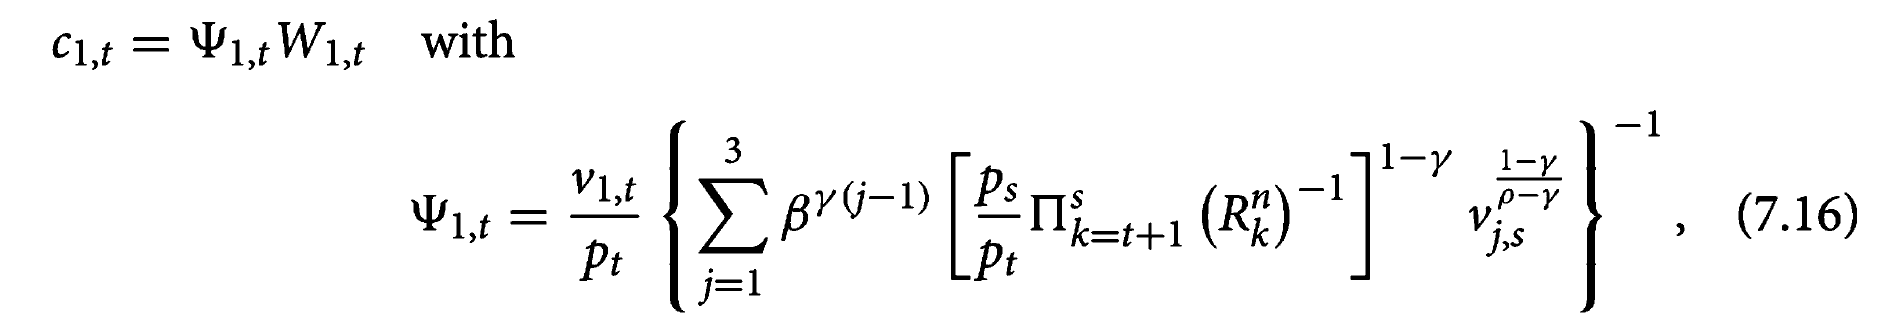

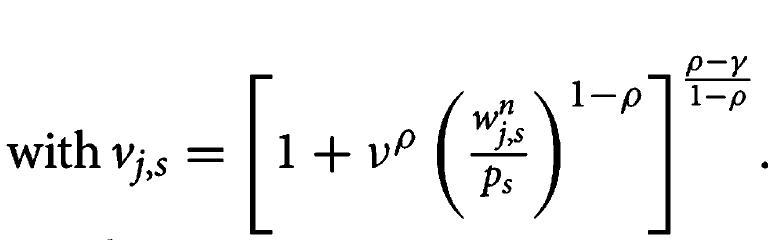

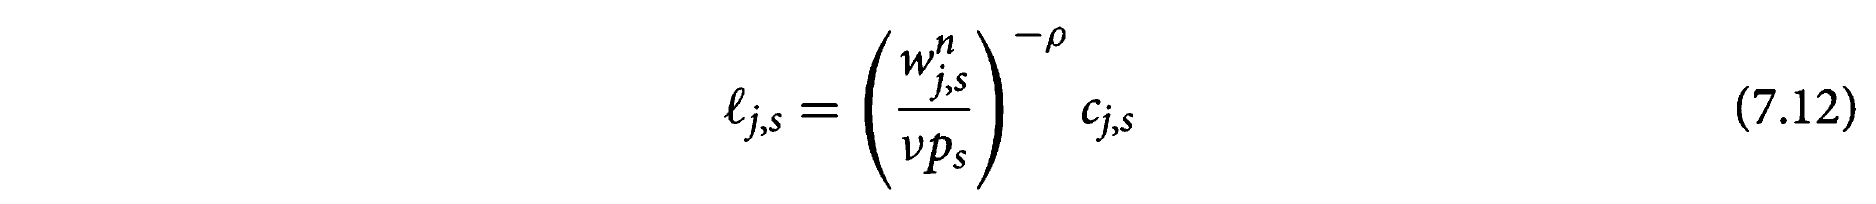

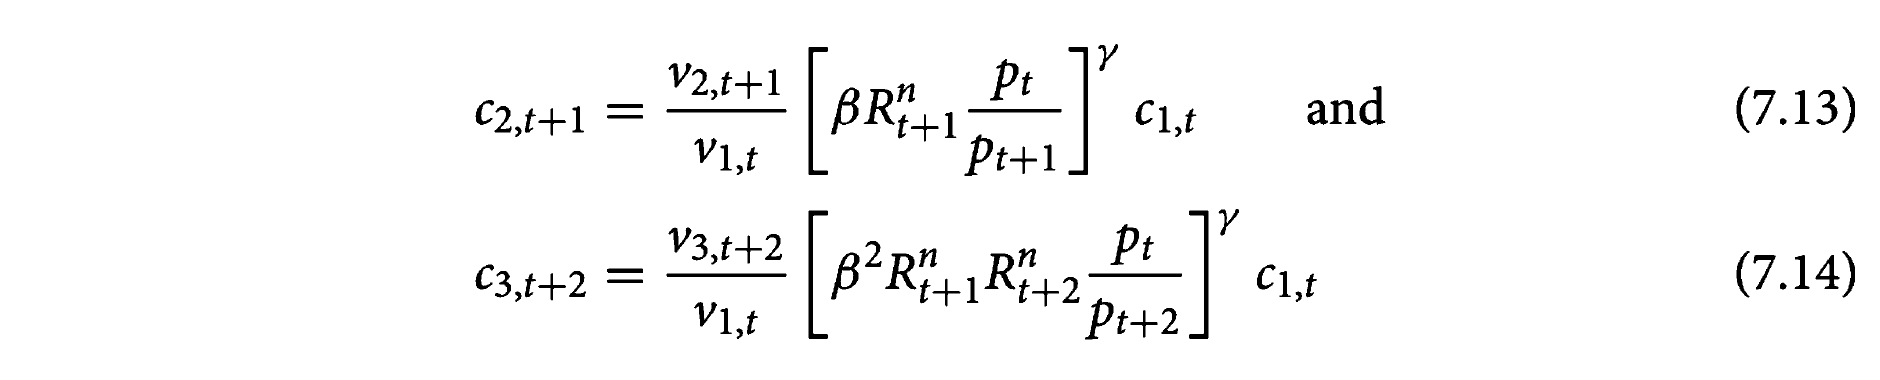

In [5]:
## Calculating the optimal consumption path

def get_path(j,t):
    """This function calculates the optimal consumption path at each age j at period t."""
    
    global c, a, l
    
    PRn = 1.0         #PRn in the period 0 is 1
    vv  = np.zeros(J) #initial v_{j,s}
    vv[j] = (1.0 + ν**ρ*(wn[j,t]/p[t])**(1.0-ρ))**((ρ-γ)/(1.0-ρ))  #v_{j,s} in nominator function for Ψ
    
    if ν > .0:        #if leisure is included in preference
        l[j,t] = (wn[j, t]/(ν*p[t]))**(-ρ)*c[j,t]  #w/(vp)^(-ρ)c equation (7.12)

    for jp in range(j+1,J):  #loop for future ages
        # get future and previous year as well as interest factor
        tp = year(t,j,jp)    #t+jp-j
        tm = year(t,j,jp-1)  #t+jp-j-1
        PRn = PRn*Rn[tp]     #cumulated return on capital Rn[t+1] and Rn[t+1]*Rn[t+2]
        
        # get consumption and leisure
        vv[jp] = (1.0 + ν**ρ*(wn[jp,tp]/p[tp])**(1.0-ρ))**((ρ-γ)/(1.0-ρ)) #v_{j,s}
        c[jp,tp] = vv[jp]/vv[j]*(β**(jp-j)*PRn*p[t]/p[tp])**γ*c[j,t]      #c_{2,t+1} and c_{3,t+2} equation (7.13&14)
        if ν > .0 :
            l[jp,tp] = (1-damp)*((wn[jp,tp]/(ν*p[tp]))**(-ρ)*c[jp,tp])+damp*l[jp,tp] #converging leisure
            
        # calculate assets 
        a[jp,tp] = wn[jp-1,tm]*(1.0-l[jp-1,tm]) + pen[jp-1,tm] + Rn[tm]*a[jp-1,tm] -p[tm]*c[jp-1,tm]  
        #savings as all income (labour income + pension + capital income) - consumption
        if tp == 2:                         #for t=2
            a[jp,tp] = a[jp,tp] + v[J-jp]
            a[jp,tp] = a[jp,tp] + v[tm+J-2] #a + required transfer if include welfare analysis
    return None

In [6]:
## conpute shadow wages
def shadw(j,t):
    """This function calculates the shadow price of labour with leisure constraint at each age j at period t."""
    global μ, l, do_all, n
    
    do_all = False  #logical statement: satisfis constraint

    for jp in range(j,J):      #loop for each age
        tp = year(t, j, jp)    #t, t+1, t+2
        
        # check whether leisure satisfies constraint
        if l[jp,tp]  > 1.0 or do_all:  #if l>1 or μ>0:
            μ_new    = c[jp,tp]**(1.0/ρ)*ν*p[tp]/(1.0-τw[tp]-τp[tp])-h[jp]*w[jp]  #new μ from FOC
            
            μ[jp,tp] = max((1.0-damp)*μ[jp,tp]+ damp*μ_new,.0)  #converging μ and μ>=0
            
            # once leisure doesn't satisfy constraint, adjust all future shadow wages
            do_all = True   #logical statement adjusted: constraint not satisfied
            l[jp,tp] = 1.0  #full leisure, l<=1
        else:  #otherwise, constraint is satiesfied
            μ[jp,tp] = (1-damp)*μ[jp,tp]  #converging μ
            #μ[jp,tp] = .0
            
    return None

In [7]:
## Calculating individual decisions in a certain year

def decisions(t):
    """This function defines the decisions of consumption and savings in each period t."""
    global c
    c[0,t] = get_Psi(0,t)*get_W(0,t) #c=ΨW
    
    get_path(0,t)                    #calculate consumption path at age 0 period t
    
    if ν > .0:                       #if leisure is included in the preference
        shadw(0,t)                   #get shadow price with leisure constraint at age 0 period t
    
    # derive behaviour for all other cohorts in year 1 of transition
    if t == 1:                       #at t=1
        for j in range(1,J):         #for each age
            c[j,t] = get_Psi(j,t)*get_W(j,t)    #c=ψW
            get_path(j,t)                       #calculate consumption path at age j period t
            if ν > .0:               #if leisure is included in the preference
                shadw(j,t)           #get shadow price with leisure constraint at age j period t
    return None

In [8]:
## calculating quantities in a certain year

def quantities(t):
    """This function defines the aggregated quantities of C, A, Y, I, G, B, K in period t."""
    global G, C, A, L, Y, B, K, Bf, Tb, I
    
    tm = year(t,1,0)   #time index t-1
    tp = year(t,0,1)   #time index t+1
    
    if t == 0:         #initial goverment spending
        G[t] = gy*Y[t] #goverment spending
    else:              #other periods
        G[t] = G[0]    #same as period 0
        
    # aggregate individual decisions
    C[t] = .0          #initial value of aggregate consumption
    A[t] = .0          #initial value of aggregate assets
    L[t] = .0          #initial value of aggregate labour input
    
    for j in range(J): #for all ages
        C[t] = C[t] + c[j,t]*m[j,t] #cumulated aggregate consumption with population parameters mt=m_{t-1}/(1+np)
        A[t] = A[t] + a[j,t]*m[j,t] #cumulated aggregate assets with population parameters mt=m_{t-1}/(1+np)
        L[t] = L[t] + h[j]*(1.0-l[j,t])*m[j,t] #cumulated aggregate labour input (h(1-l)) with population parameters mt=m_{t-1}/(1+np)
    
    Y[t] = K[t]**α*L[t]**(1.0-α)    #aggregate output
    B[t] = by[tm]*Y[t]              #aggregate government debt
    
    # derive capital in small open or closed economy
    if smopec and t>0:
        K[t]  = L[t]*((r[t]*(1.0/(1.0-τk[t])) + δ)/α)**(1.0/(α-1.0)) #converted from r=α(K/L)^(α-1)H^ϵ-δ 
        Bf[t] = A[t] - K[t] - Ba[t] - B[t]               #debt constraint
        Tb[t] = (1.0+n_p[tp])*Bf[tp] - (1.0+r[t])*Bf[t]  #total debt
    else:
        K[t] = damp*(A[t]-B[t]-Ba[t]) + (1.0-damp)*K[t]  #converging capital stock
    
    I[t] = (1.0+n_p[tp])*K[tp] - (1.0 - δ)*K[t]          #aggregate investment
    
    return None

In [9]:
# calculating government parameters

def government(t):
    """This function defines the government parameters and tax revenues at period t."""
    global τc, τk, τw, τr, pen, Tpen, τp, TXr
    tp = year(t, 0, 1)
    
    taxrev = np.zeros(4)           #set 4 types of taxes
    
    taxrev[0] = τc[t]*C[t]         #total consumption tax
    taxrev[1] = τw[t]*w[t]*L[t]    #total labour income tax
    taxrev[2] = τr[t]*r[t]*A[t]    #total capital income tax
    taxrev[3] = τk[t]*(Y[t] - w[t]*L[t]-(δ)*K[t])  #total savings or investment tax
    
    # get budget balancing tax rate
    if tax[t] == 1:      #(government surplus-τcC)/C
        τc[t] = ((1.0 + r[t])*B[t] + G[t] - (taxrev[1] + taxrev[2] + \
                    taxrev[3]+(1.0 + n_p[tp])*B[tp]))/C[t]   
    elif tax[t] == 2:    #[government surplus-τw(wL)-τr(rA)]/(wL+rA) assuming same labour and capital income tax
        τw[t] = ((1.0 + r[t])*B[t] + G[t] - (taxrev[0] + taxrev[3] + \
                    (1.0+n_p[tp])*B[tp]))/(w[t]*L[t] + r[t]*A[t])
        τr[t] = τw[t]    #same labour and capital income tax
    elif tax[t] == 3:    #[government surplus-τw(WL)]/(wL)
        τw[t] = ((1.0 + r[t])*B[t] + G[t] - (taxrev[0] + taxrev[2] + \
                    taxrev[3] + (1.0 + n_p[tp])*B[tp]))/(w[t]*L[t])
    else:                #[government surplus-τr(rA)]/(rA)
        τr[t] = ((1.0 + r[t])*B[t] + G[t] - (taxrev[0] + taxrev[1] + \
                    taxrev[3]+ (1.0 + n_p[i])*B[tp]))/(r[t]*A[t])
    
    TXr[t] = np.sum(taxrev)   #total tax revenue
    
    # get budget balancing social security contribution
    pen[JR-1:J,t] = κ[t]*w[t] #pension at each period
    Tpen[t] = .0              #initial total pension
    for j in range(JR-1,J):   #for retired periods
        Tpen[t] = Tpen[t] + pen[j,t]*m[j,t] #total pension with population parameters mt=m_{t-1}/(1+np)
        
    τp[t] = Tpen[t]/(w[t]*L[t]) #payroll tax rate
    return None

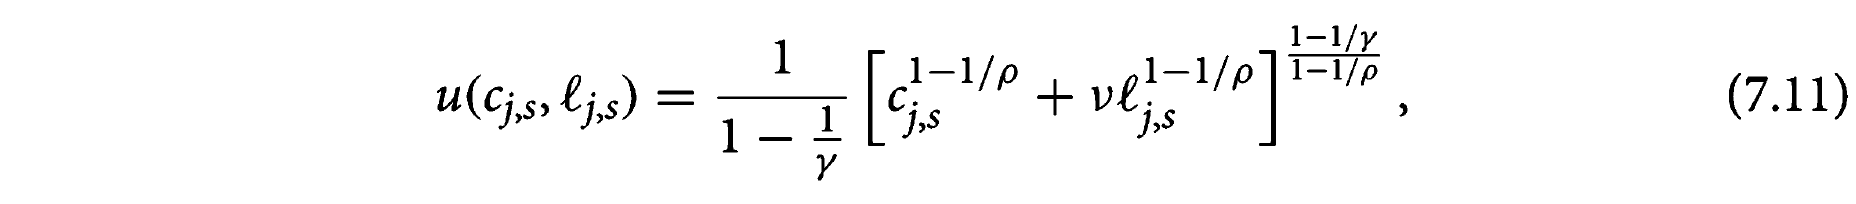

In [10]:
## Compute household utility

def utility(t):
    """This function defines expected utility at each age for each period i in [0,T]."""
    global U
    U[0,t] = .0
    
    # for first generation
    for j in range(J):
        U[j,t] = .0
        for jp in range(j,J):  #preference equation (7.11)
            tp = year(t, j, jp)
            U[j,t] = U[j,t] + β**(jp-j)*(c[jp,tp]**eρ + ν*l[jp,tp]**eρ)**(egam/eρ)/egam
    
    # for current total population if year = 0 or 1
    if t < 2:
        for j in range(1,J):
            U[j,t] = .0
            for jp in range(j,J):
                tp = year(t, j, jp)
                U[j,t] = U[j,t] + β**(jp-j)*(c[jp,tp]**eρ + ν*l[jp,tp]**eρ)**(egam/eρ)/egam
                
    return None

In [11]:
# solves inital steady state using Gauss-Seidel

def get_SteadyState():
    """This function calculates inital steady state using Gauss-Seidel."""
    K[0] = 1.0
    L[0] = 1.0
    for i in range(itermax+1):
        factor_prices(0)
        decisions(0)
        quantities(0)
        government(0)
        utility(0)
        '''
        for j in range(J):
            if l[j,0]<1.0:
                μ[j,0] = .0
            if l[j,0]>=1.0:
                l[j,0]=1.0
        '''
        #print('Iteration: ', i, ' Diff: ',abs(Y[0]-C[0]-I[0]-G[0])/Y[0],"%.2f"%l[2,0])
        if abs(Y[0]-C[0]-I[0]-G[0])/Y[0] < tol:
            break
    
    #if i < itermax:
        #print('Iteration: ', i, ' Diff: ',abs(Y[0]-C[0]-I[0]-G[0])/Y[0])
    #else:
        #print('!!! No equilibrium found !!!')
    
    return None

In [12]:
## sovles for transition path using Gauss-Seidel:

def get_Transition():
    """This function calculates each period economy and checks for market clearing conditions."""
    global a, K, L, HEV
    # Initialize values from initial equilibrium
    a[:,1] = a[:,0]
    K[:] = K[0]
    L[:] = L[0]
    nmarket = 0   #iteration index
    
    for ite in range(itermax+2):
        # get prices, decisions and quantites
        for t in range(1,T+1):
            factor_prices(t)
        
        for t in range(1,T+1):
            decisions(t)
        # if include welfare analysis
        if lsra_on:
            lsra()
        
        for t in range(1,T+1):
            quantities(t)
        
        for t in range(1,T+1):
            government(t)
            
        # check for the number of markets in equilibrium
        nmarket = 0
        for t in range(1,T+1):
            if  abs(Y[t]-C[t]-I[t]-G[t]-Tb[t])/Y[t] < tol:
                nmarket = nmarket + 1
        if nmarket == T:
            break
        
    if ite > itermax:
        print('!!! No equilibrium found !!!')
    else:
        print('Iteration: ',ite,' Markets: ',nmarket,' Diff: ',np.max(np.abs(Y-C-I-G-Tb)/Y))
    
    for t in range(T+1):
        utility(t)
    HEV = np.zeros(T+2)   #Hicksian equivalent vairation (HEV or CEV) C for consumption
    for t in range(2,T+2):
        HEV[t] = ((U[0,t-1]/U[0,0])**(1/egam)-1)*100
    HEV[1] = -((U[1,0]/U[1,1])**(1/egam)-1)*100 # generation 0
    HEV[0] = -((U[2,0]/U[2,1])**(1/egam)-1)*100 # generation -1
    return None

In [13]:
## Table 7.1
def table1(simu):
    global h, tol
    initialize()
    if simu == 0:
        h = np.array([1.0,1.0,1.0])
        tol = 1e-6
    if simu == 1:
        h = np.array([0.5,1.0,1.5]) 
        tol = 1e-6
    if simu == 2:
        h = np.array([1.5,1.0,0.5])
        tol = 1e-4
    if simu == 3:
        h = np.array([0.5,2.0,0.5])
        tol = 1e-3
    return None
print('Table 7.1 Long-run analysis of human-capital profile')
print('--------------------------------------------------------')
print('   h1  h2  h3   l1   l2   l3    K   μ3    w    r    U')
for simu in range(4):
    table1(simu)
    get_SteadyState()
    print('--------------------------------------------------------')
    print(simu,'%.1f'%h[0],'%.1f'%h[1],'%.1f'%h[2],'%.2f'%l[0,0],'%.2f'%l[1,0],'%.2f'%l[2,0],\
          '%.2f'%K[0],'%.2f'%μ[2,0],'%.2f'%w[0],'%.2f'%r[0],'%.2f'%U[0,0])

Table 7.1 Long-run analysis of human-capital profile
--------------------------------------------------------
   h1  h2  h3   l1   l2   l3    K   μ3    w    r    U
--------------------------------------------------------
0 1.0 1.0 1.0 0.37 0.54 0.78 0.14 0.00 0.37 1.35 -31.80
--------------------------------------------------------
1 0.5 1.0 1.5 0.33 0.43 0.68 0.04 0.00 0.25 3.27 -47.15
--------------------------------------------------------
2 1.5 1.0 0.5 0.38 0.62 0.97 0.29 0.06 0.45 0.84 -25.93
--------------------------------------------------------
3 0.5 2.0 0.5 0.40 0.36 0.97 0.05 0.11 0.25 3.17 -40.21


In [14]:
## Table 7.2
initialize()
h = np.array([2.0,2.0,0.0])
gy = 0.195
tax[1:T+1] = 3
get_SteadyState()
get_Transition()
print('---------------------------------------------')
print('Table 7.2 From consumption to labour-income \ntaxation with variable labour supply')
print('---------------------------------------------')
print(' t   τw   τc    C    L    K    w    r   HEV')
print(-1,'                                  ','%2.2f'%HEV[0])
list1 = [0, 1, 2, 3, 4]
for t in list1:
    print('%2.f'%t,'%.2f'%τw[t],'%.2f'%τc[t],'%.2f'%C[t],'%.2f'%L[t],'%.2f'%K[t],'%.2f'%w[t],'%.2f'%r[t],'%2.2f'%HEV[t+1])
print(' .   .    .    .    .    .    .    .    . ')
print(' .   .    .    .    .    .    .    .    . ')
print(' .   .    .    .    .    .    .    .    . ')
for t in [T]:
    print(' T','%.2f'%τw[t],'%.2f'%τc[t],'%.2f'%C[t],'%.2f'%L[t],'%.2f'%K[t],'%.2f'%w[t],'%.2f'%r[t],'%2.2f'%HEV[t+1])

!!! No equilibrium found !!!
---------------------------------------------
Table 7.2 From consumption to labour-income 
taxation with variable labour supply
---------------------------------------------
 t   τw   τc    C    L    K    w    r   HEV
-1                                    9.75
 0 0.00 0.26 0.85 1.91 0.33 0.41 1.02 5.20
 1 0.28 0.00 0.90 1.86 0.33 0.42 1.00 -3.34
 2 0.30 0.00 0.82 1.91 0.27 0.39 1.19 -6.57
 3 0.31 0.00 0.77 1.93 0.24 0.37 1.31 -9.08
 4 0.31 0.00 0.75 1.95 0.22 0.37 1.37 -9.46
 .   .    .    .    .    .    .    .    . 
 .   .    .    .    .    .    .    .    . 
 .   .    .    .    .    .    .    .    . 
 T 0.31 0.00 0.74 1.95 0.21 0.36 1.41 -9.80


In [15]:
## Table 7.3
initialize()
h = np.array([2.0,2.0,0.0])
gy = 0.195
κ[1:] = .5
get_SteadyState()
get_Transition()
print('-----------------------------------------------')
print('Table 7.3 Introduction of pay-as-you-go pensions \nwith variable labour supply')
print('-----------------------------------------------')
print(' t    κ   τp    τc   C    L    K     w    r   HEV')
print(-1,'                                       ','%2.2f'%HEV[0])
for t in list1:
    print('%2.f'%t,'%.2f'%κ[t],'%.2f'%τp[t],'%.2f'%τc[t],'%.2f'%C[t],'%.2f'%L[t],'%.2f'%K[t],'%.2f'%w[t],'%.2f'%r[t],'%2.2f'%HEV[t+1])
print(' .   .    .    .    .    .    .    .    .    . ')
print(' .   .    .    .    .    .    .    .    .    . ')
print(' .   .    .    .    .    .    .    .    .    . ')
for t in [T]:
    print(' T','%.2f'%κ[t],'%.2f'%τp[t],'%.2f'%τc[t],'%.2f'%C[t],'%.2f'%L[t],'%.2f'%K[t],'%.2f'%w[t],'%.2f'%r[t],'%2.2f'%HEV[t+1])

!!! No equilibrium found !!!
-----------------------------------------------
Table 7.3 Introduction of pay-as-you-go pensions 
with variable labour supply
-----------------------------------------------
 t    κ   τp    τc   C    L    K     w    r   HEV
-1                                         13.52
 0 0.00 0.00 0.26 0.85 1.91 0.33 0.41 1.02 3.10
 1 0.50 0.19 0.24 0.91 1.85 0.33 0.42 0.99 -5.00
 2 0.50 0.18 0.29 0.77 1.88 0.24 0.38 1.25 -8.94
 3 0.50 0.18 0.30 0.74 1.91 0.22 0.36 1.38 -10.45
 4 0.50 0.18 0.31 0.72 1.91 0.20 0.36 1.44 -11.20
 .   .    .    .    .    .    .    .    .    . 
 .   .    .    .    .    .    .    .    .    . 
 .   .    .    .    .    .    .    .    .    . 
 T 0.50 0.18 0.31 0.70 1.92 0.20 0.35 1.47 -11.74
